In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, pandas as pd, scipy
import astropy
from astropy import units as u
import astromet
from astromet.track import design_matrix, design_1d
#import dev.astromet.astromet as astromet
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import scanninglaw.times
from scanninglaw.source import Source

In [3]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=2
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

In [4]:
dr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

# Load in scanning law
- Requires scanninglaw installed
- Takes up a bit of memory (~1Gb I think)

In [5]:
# slooow step - see scanning_law package for details
dr3_sl=scanninglaw.times.dr2_sl(version='dr3_nominal')

Loading auxilliary data ...
t = 40.297 s
  auxilliary:  19.387 s
          sf:   6.082 s
interpolator:  14.828 s


## Along scan error

In [6]:
# Individual measurement error
sigma_al = np.array(pd.read_csv('astromet/data/scatteral_edr3.csv', usecols=['magbin','var_al_50']))
sigma_al_interp = scipy.interpolate.interp1d(sigma_al[:,0], sigma_al[:,1], bounds_error=False)

# Single source

In [16]:
# System astrometry parameters
params=astromet.params()
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
params.pmrac=params.parallax*np.random.normal(scale=6.67)
params.pmdec=params.parallax*np.random.normal(scale=6.67)

params.rac = params.ra*np.cos(np.deg2rad(params.dec))
#params.pmra = params.pmrac/np.cos(np.deg2rad(params.dec))

params.phot_g_mean_mag=np.random.rand()*6+15

c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=ts[sort]
phis=np.squeeze(np.hstack(sl['angles']))[sort]

# Get rid of binary signal for the moment
params.a = 0.

In [22]:
drac_track, ddec_track=astromet.track(ts,params)

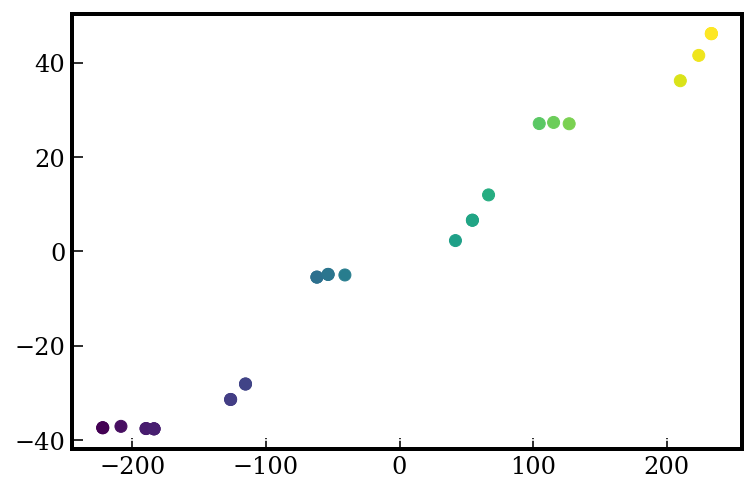

In [23]:
plt.scatter(rac_track, 
            dec_track, c=ts)

In [24]:
x_true = rac_track * np.sin(np.deg2rad(phis)) + dec_track * np.cos(np.deg2rad(phis))
x_err = sigma_al_interp(params.phot_g_mean_mag)

In [25]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec

(116.83017697160189,
 53.11787711164644,
 10.60728762688539,
 162.9251119809149,
 32.22378559859908)

In [26]:
# 'pmra' in gaia data is pmra*cos(dec) 
gaia_output=astromet.gaia_fit(ts,x_true,phis,x_err,params.ra,params.dec)
gaia_output

{'astrometric_matched_transits': 29,
 'visibility_periods_used': 17,
 'astrometric_n_obs_al': 261,
 'astrometric_params_solved': 31,
 'ra': 116.83017696788824,
 'ra_error': 0.025415453388846418,
 'dec': 53.11787710826735,
 'dec_error': 0.023541405812770505,
 'ra_dec_corr': 0.036220614283925305,
 'parallax': 10.588901490919602,
 'parallax_error': 0.031872325834593845,
 'ra_parallax_corr': 0.010387903690619997,
 'dec_parallax_corr': 0.1322594738158224,
 'pmra': 162.921346540451,
 'pmra_error': 0.029765353839836743,
 'ra_pmra_corr': 0.1333355575357683,
 'dec_pmra_corr': 0.1435416063486884,
 'parallax_pmra_corr': -0.35822798891039453,
 'pmdec': 32.18526705042632,
 'pmdec_error': 0.025390978251270888,
 'ra_pmdec_corr': 0.2007921241878261,
 'dec_pmdec_corr': 0.18232858174900463,
 'parallax_pmdec_corr': 0.010396917058740945,
 'pmra_pmdec_corr': 0.15472860931818708,
 'astrometric_excess_noise': 0.034224535455268136,
 'astrometric_chi2_al': 272.3663561933159,
 'astrometric_n_good_obs_al': 261,


### UWE~1 and astrometric_excess_noise is small (as expected without binary motion)

# Binary source

In [27]:
# System astrometry parameters
params=astromet.params()
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
params.pmrac=params.parallax*np.random.normal(scale=6.67)
params.pmdec=params.parallax*np.random.normal(scale=6.67)

params.rac = params.ra*np.cos(np.deg2rad(params.dec))

params.phot_g_mean_mag=np.random.rand()*6+10

c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=ts[sort]
phis=np.squeeze(np.hstack(sl['angles']))[sort]

params.period=10**(-1.5+3*np.random.rand()) # periods between 0.03 and 30 years
params.l=np.random.rand() # uniform light ratio
params.q=4*np.random.rand()**2 # mass ratios between 0 and 4 (half less than 1)
params.a=10*np.random.rand()**2
params.e=np.random.rand()
params.vtheta=np.arccos(-1+2*np.random.rand())
params.vphi=2*np.pi*np.random.rand()
params.vomega=2*np.pi*np.random.rand()
orbitalPhase=np.random.rand() # fraction of an orbit completed at t=0
params.tperi=params.period*orbitalPhase

In [28]:
rac_track, dec_track=astromet.track(ts,params)

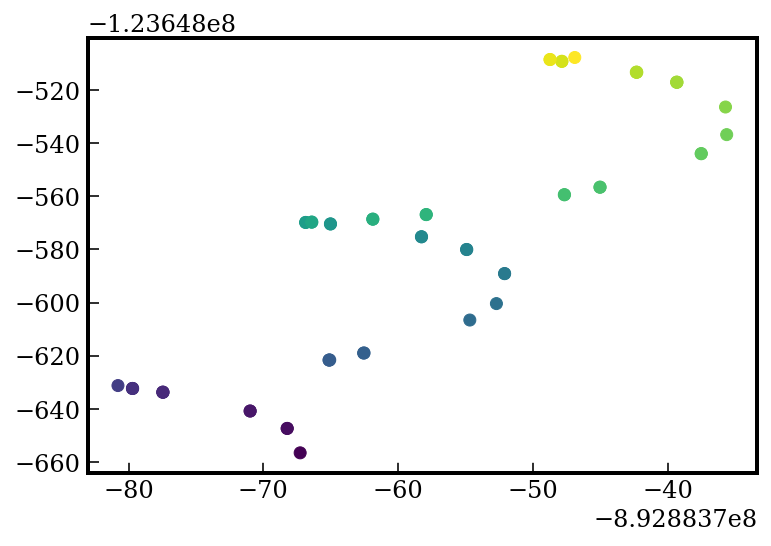

In [29]:
plt.scatter(rac_track-params.rac/astromet.mas, 
            dec_track-params.dec/astromet.mas, c=ts)

In [30]:
x_true = rac_track * np.sin(np.deg2rad(phis)) + dec_track * np.cos(np.deg2rad(phis))
x_err = sigma_al_interp(params.phot_g_mean_mag)

In [31]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec

(300.40215783339545,
 34.34682943424671,
 11.1077870246565,
 16.17913907566109,
 61.63649816311256)

In [32]:
# 'pmra' in gaia data is pmra*cos(dec) 
gaia_output=astromet.gaia_fit(ts,x_true,phis,x_err,params.ra,params.dec)
gaia_output

{'astrometric_matched_transits': 54,
 'visibility_periods_used': 27,
 'astrometric_n_obs_al': 486,
 'astrometric_params_solved': 31,
 'ra': 300.4021578397281,
 'ra_error': 0.055425391529280874,
 'dec': 34.34682925803294,
 'dec_error': 0.06159796323965858,
 'ra_dec_corr': -0.0885099680897849,
 'parallax': 10.874102411804877,
 'parallax_error': 0.07445313228870806,
 'ra_parallax_corr': 0.012546722890576715,
 'dec_parallax_corr': -0.08589045577326765,
 'pmra': 15.853119820225876,
 'pmra_error': 0.07503857346714243,
 'ra_pmra_corr': -0.14909781035303124,
 'dec_pmra_corr': 0.03721780348869471,
 'parallax_pmra_corr': 0.12091443847508986,
 'pmdec': 61.25942513316463,
 'pmdec_error': 0.0792086492703763,
 'ra_pmdec_corr': 0.04939466104547883,
 'dec_pmdec_corr': -0.2118000160434509,
 'parallax_pmdec_corr': 0.0866605412178178,
 'pmra_pmdec_corr': -0.051256314410551194,
 'astrometric_excess_noise': 0.7894537225727558,
 'astrometric_chi2_al': 310569.2315844586,
 'astrometric_n_good_obs_al': 486,
 '

### UWE is bigger and astrometric_excess_noise>0!

# Iterate over many sources

In [34]:
nTest=100

# Construct Gaia data model
astrometry_coords = ['ra','dec','parallax','pmra','pmdec']
astrometry_gaia = astrometry_coords + \
                [astrometry_coords[i]+'_error' for i in range(5)] + \
                [astrometry_coords[i]+'_'+astrometry_coords[j]+'_corr' for i in range(5) for j in range(i+1,5)] + \
                ['astrometric_excess_noise', 'astrometric_chi2_al', 
                 'astrometric_n_good_obs_al', 'astrometric_n_obs_al',
                 'astrometric_matched_transits', 'visibility_periods_used', 'astrometric_params_solved']


dataNames=['rac_true','dec_true','pmrac_true','pmdec_true','parallax_true','phot_g_mean_mag',
           'M_tot','q','l','a','e','P','tPeri',
           'vTheta','vPhi','vOmega',
           'predict_dTheta','simple_dTheta',
           'sigma_al','sigma_ac','UWE']+astrometry_gaia
allData=astropy.table.Table(names=dataNames)

# we'll generate nTest sets of parameters, and test each with a 0, 2 ,5 and 10 mSun BH
for i in tqdm.tqdm_notebook(range(nTest)):
    allData.add_row()
    thisRow=allData[i]
    
    # System astrometry & photometry parameters
    params=astromet.params()
    params.ra=360*np.random.rand()
    params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
    params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
    params.pmra=params.parallax*np.random.normal(scale=6.67)
    params.pmdec=params.parallax*np.random.normal(scale=6.67)
    params.phot_g_mean_mag=np.random.rand()*6+15    
    
    params.rac = params.ra*np.cos(np.deg2rad(params.dec))
    params.pmra = params.pmrac/np.cos(np.deg2rad(params.dec))
    
    # Scanning law information
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]
    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    # Binary parameters
    params.period=10**(-1.5+3*np.random.rand()) # periods between 0.03 and 30 years
    params.l=np.random.rand() # uniform light ratio
    params.q=4*np.random.rand()**2 # mass ratios between 0 and 4 (half less than 1)
    params.a=10*np.random.rand()**2
    params.e=np.random.rand()
    params.vtheta=np.arccos(-1+2*np.random.rand())
    params.vphi=2*np.pi*np.random.rand()
    params.vomega=2*np.pi*np.random.rand()
    orbitalPhase=np.random.rand() # fraction of an orbit completed at t=0
    params.tperi=params.period*orbitalPhase
    
    # Calculate track
    drac_track, ddec_track = astromet.track(ts,params)
    x_true = drac_track * np.sin(np.deg2rad(phis)) + ddec_track * np.cos(np.deg2rad(phis))
    x_err = sigma_al_interp(params.phot_g_mean_mag)
    
    # Fit with Gaia emulator
    gaia_output=astromet.gaia_fit(ts,x_true,phis,x_err,params.ra,params.dec)
    # pmra in gaia_output includes the cos(dec) (standard gaia notation)
    
    for key in astrometry_gaia:
        thisRow[key] = gaia_output[key]    
    
    # Add to dataset
    thisRow['rac_true']=1.*params.rac
    thisRow['dec_true']=1.*params.dec
    thisRow['pmrac_true']=params.pmrac
    thisRow['pmdec_true']=params.pmdec
    thisRow['parallax_true']=params.parallax
    thisRow['phot_g_mean_mag']=params.phot_g_mean_mag
    
    thisRow['M_tot']=4*(np.pi**2)*astromet.Galt/((params.period**2)*(params.a**3))
    thisRow['q']=params.q
    thisRow['l']=params.l
    thisRow['a']=params.a
    thisRow['e']=params.e
    thisRow['P']=params.period
    thisRow['tPeri']=1.*params.tperi
    thisRow['vTheta']=params.vtheta
    thisRow['vPhi']=params.vphi
    thisRow['vOmega']=params.vomega
    
    thisRow['simple_dTheta']=astromet.dtheta_simple(params)
    #thisRow['predict_dTheta']=astromet.dtheta_full(params,np.min(ts),np.max(ts))  

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

/home/andy/Documents/Research/Projects/GitRepos/astrometpy/astromet/track.py:419: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(epsxsq+epsysq-(epsx**2)-(epsy**2))


# findEtas is throwing bugs in dtheta_full...